In [1]:
! rm -rf tools_classifier
! git clone https://github.com/zRafaF/tools_classifier

Cloning into 'tools_classifier'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (242/242), done.
remote: Total 597 (delta 13), reused 248 (delta 10), pack-reused 343 (from 1)
Receiving objects: 100% (597/597), 155.84 MiB | 14.13 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (667/667), done.


In [137]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import json
import pandas as pd
from tensorflow import keras

from google.colab.patches import cv2_imshow

In [75]:
DATA_SET_PATH = './tools_classifier/data_set/c_r_a_g_png'
BBOX_PATH = './tools_classifier/data_set/bounding_boxes.json'
METADATA_PATH = './tools_classifier/data_set/metadata.json'

In [136]:
bounding_boxes = json.load(open(BBOX_PATH))
print(bounding_boxes)

metadata = json.load(open(METADATA_PATH))
print(metadata['classes'])

class_names = list(metadata['classes'].values())
print(class_names)

[{'class': 'clamp', 'filename': '1-01-V2-W.png', 'bbox': [135, 426, 171, 396]}, {'class': 'clamp', 'filename': '1-01-V1-W.png', 'bbox': [136, 415, 135, 357]}, {'class': 'clamp', 'filename': '1-01-V1-B.png', 'bbox': [86, 380, 77, 324]}, {'class': 'clamp', 'filename': '1-01-V2-B.png', 'bbox': [102, 398, 101, 326]}, {'class': 'wrench', 'filename': '9-01-V2-W.png', 'bbox': [133, 396, 168, 344]}, {'class': 'wrench', 'filename': '9-01-V2-B.png', 'bbox': [130, 427, 232, 311]}, {'class': 'wrench', 'filename': '9-01-V1-B.png', 'bbox': [140, 424, 217, 344]}, {'class': 'wrench', 'filename': '9-01-V1-W.png', 'bbox': [142, 403, 166, 361]}, {'class': 'screw_driver', 'filename': '8-01-V2-B.png', 'bbox': [44, 471, 175, 400]}, {'class': 'screw_driver', 'filename': '8-01-V1-W.png', 'bbox': [135, 415, 169, 394]}, {'class': 'screw_driver', 'filename': '8-01-V1-B.png', 'bbox': [20, 477, 188, 342]}, {'class': 'screw_driver', 'filename': '8-01-V2-W.png', 'bbox': [152, 435, 148, 371]}, {'class': 'razor_knife'

In [77]:
def filter_bbox(bounding_boxes, img_class, img_filename):
  for bbox in bounding_boxes:
    if bbox['class'] == img_class:
      splitted_bbox_filename = bbox['filename'].split(".")[0].split("-")
      splitted_img_filename = img_filename.split(".")[0].split("-")

      # Checando se a variação da imagem é igual
      if (splitted_bbox_filename[0] == splitted_img_filename[0]
          and splitted_bbox_filename[2] == splitted_img_filename[2]
          and splitted_bbox_filename[3] == splitted_img_filename[3]):
        return bbox['bbox']


# Pre processamento de imagens

Para utilizar menos memoria durante o treino vamos redimencionar todas as imagens e carregalas à memória

In [103]:
IMAGE_SIZE = 40
IMAGE_CHANNELS = 3

Primeiro vamos carregar as imagens onde:
* `x_train_full`: são as imagens do dataset
* `y_train_full`: São as classes da imagens

In [138]:
def image_pre_process(image, bounding_box):
  if IMAGE_CHANNELS == 1:
    # Convertendo para escala de cinza caso queira
    image = rgb2gray(image)
  image = image[bounding_box[2]:bounding_box[3], bounding_box[0]:bounding_box[1]]

  image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  return image

In [105]:
x_train_full = []
y_train_full = []

for dir in os.listdir(DATA_SET_PATH):
  data_set_dir = os.path.join(DATA_SET_PATH, dir)

  for filename in os.listdir(data_set_dir):
    if filename.endswith('.png'):
        img_path = os.path.join(data_set_dir, filename)
        image = io.imread(img_path)
        splitted = filename.split(".")[0].split("-")

        bbox = filter_bbox(bounding_boxes, dir, filename)

        pre_process_image = image_pre_process(image, bbox)

        x_train_full.append(pre_process_image)
        y_train_full.append(int(splitted[0]))

unique_classes = list(set(y_train_full))
images_per_class = int(len(x_train_full) / len(unique_classes))
num_of_classes = int(len(unique_classes))

print(f'Classes: {num_of_classes}')
print(f'Imagens por classe: {images_per_class}')

Classes: 7
Imagens por classe: 16


In [126]:
def display_images(dataset, dataset_labels, unique_classes, metadata, title="Dataset Display"):
    fig, axes = plt.subplots(len(unique_classes), images_per_class, figsize=(images_per_class * 2, len(unique_classes) * 2))

    for i, class_id in enumerate(unique_classes):
        class_indices = [j for j, y in enumerate(dataset_labels) if y == class_id]
        if len(class_indices) == 0:
            continue  # Skip classes with no images in the dataset

        for j, idx in enumerate(class_indices[:images_per_class]):
            axes[i, j].imshow(dataset[idx], cmap="gray" if IMAGE_CHANNELS == 1 else None)
            axes[i, j].axis('off')
            axes[i, j].set_title(metadata['classes'][f'{class_id}'])

        for j in range(len(class_indices), images_per_class):
            axes[i, j].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

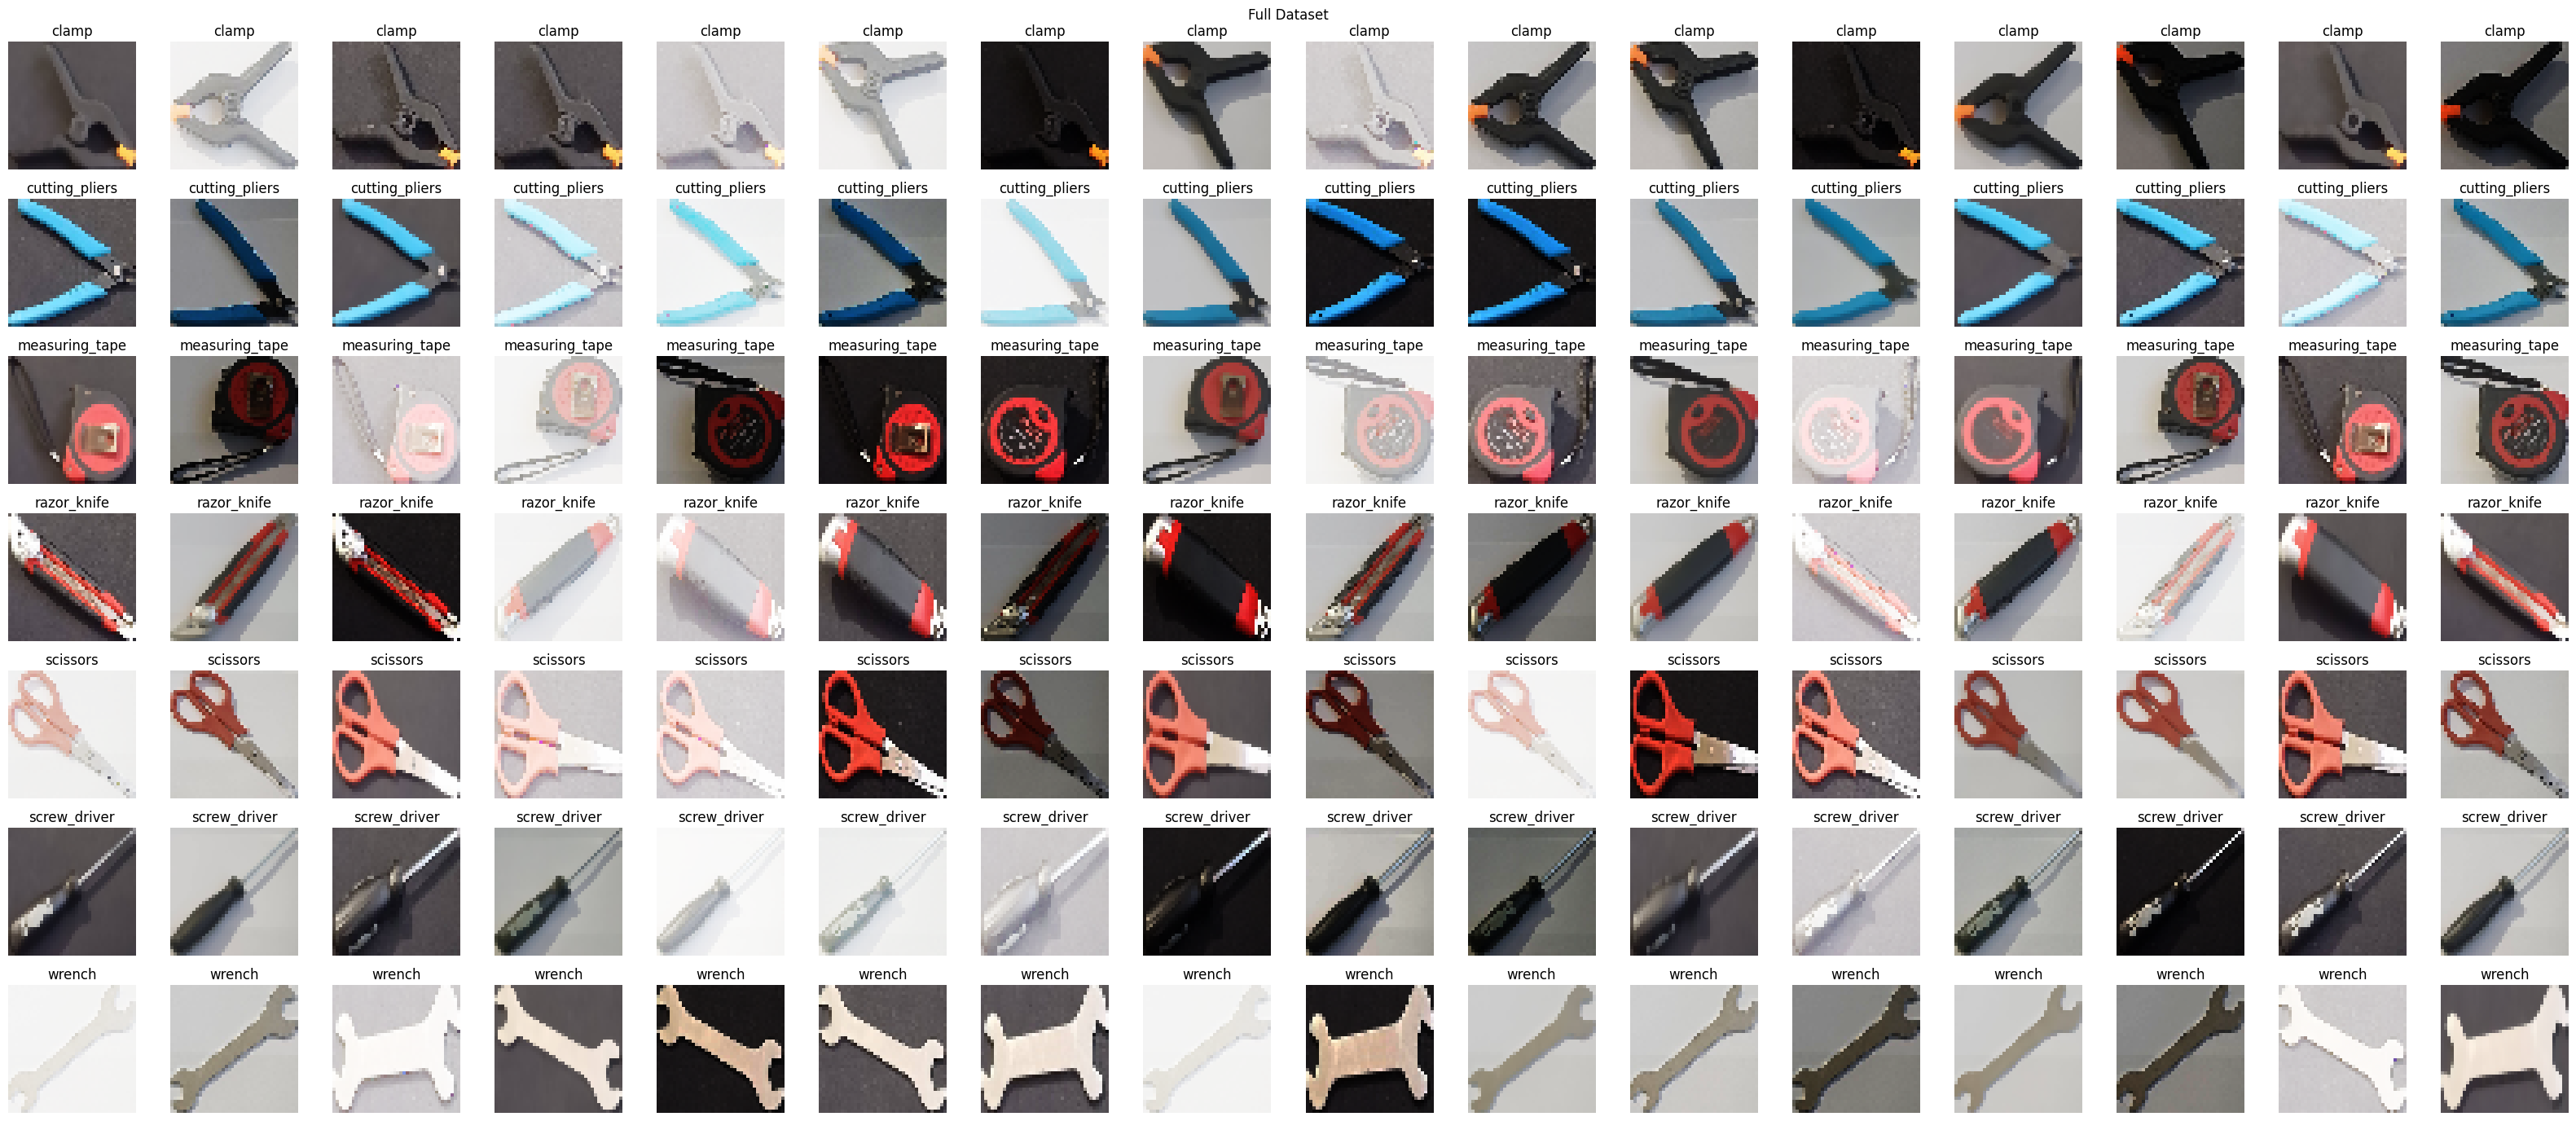

In [125]:
display_images(x_train_full, y_train_full, unique_classes, metadata, title="Full Dataset")

Dividindo imagens em:
* 80% treino
* 10% validação
* 10% teste

In [107]:
x_training = []
y_training = []

x_validation = []
y_validation = []

x_test = []
y_test = []

for idx, x in enumerate(x_train_full):
  if idx % 10 == 0:
    x_test.append(x)
    y_test.append(y_train_full[idx])
  elif idx % 10 == 1:
    x_validation.append(x)
    y_validation.append(y_train_full[idx])
  else:
    x_training.append(x)
    y_training.append(y_train_full[idx])


y_training = np.array(y_training)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

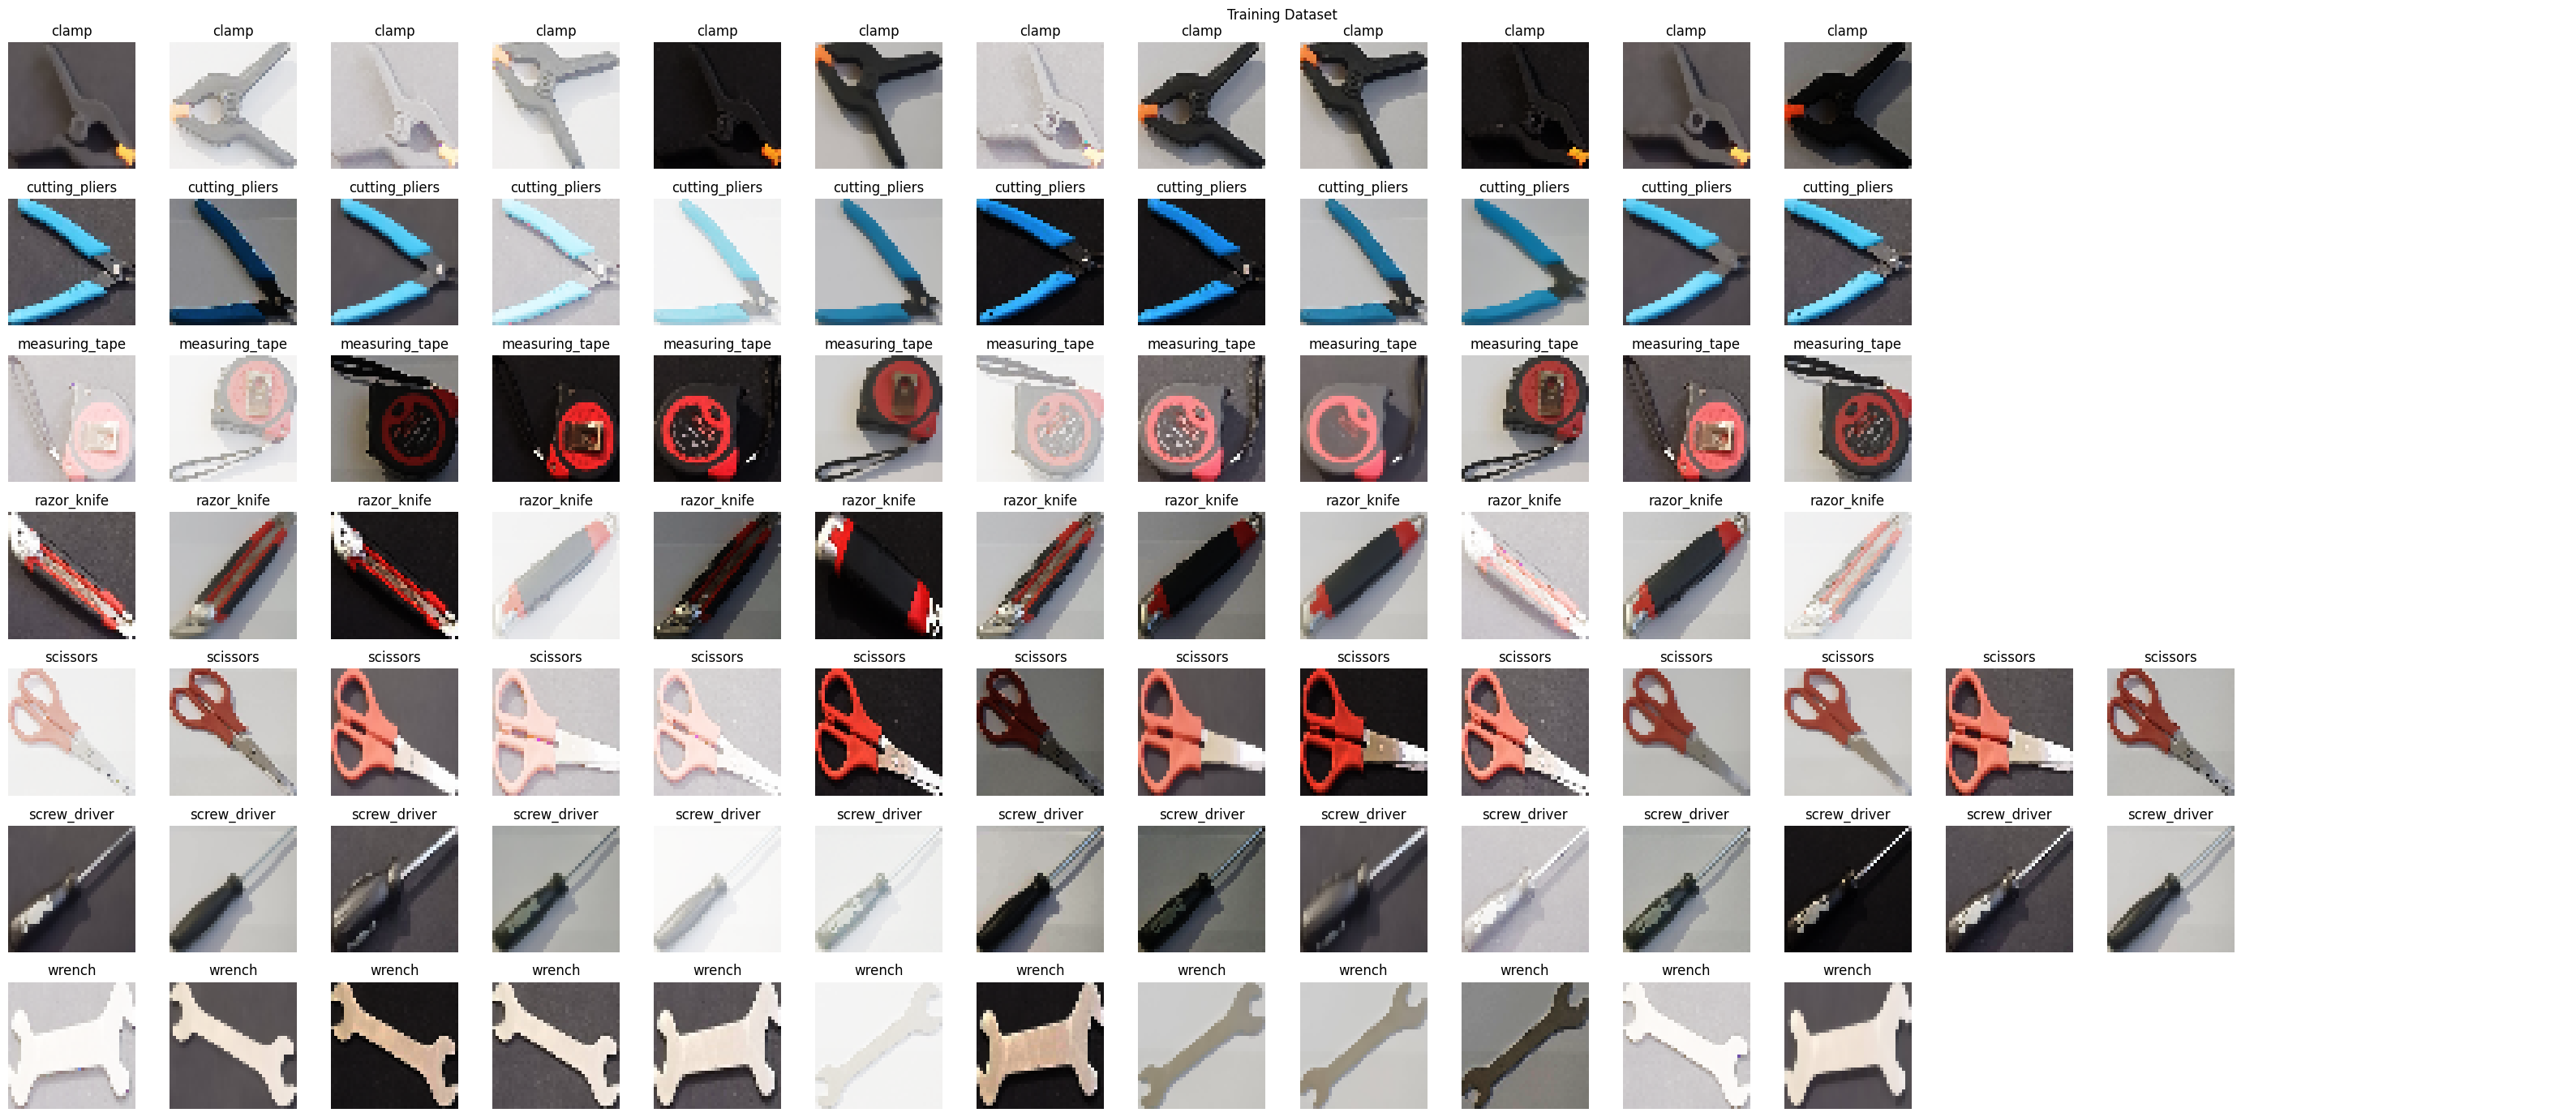

In [122]:
display_images(x_training, y_training, unique_classes, metadata, title="Training Dataset")

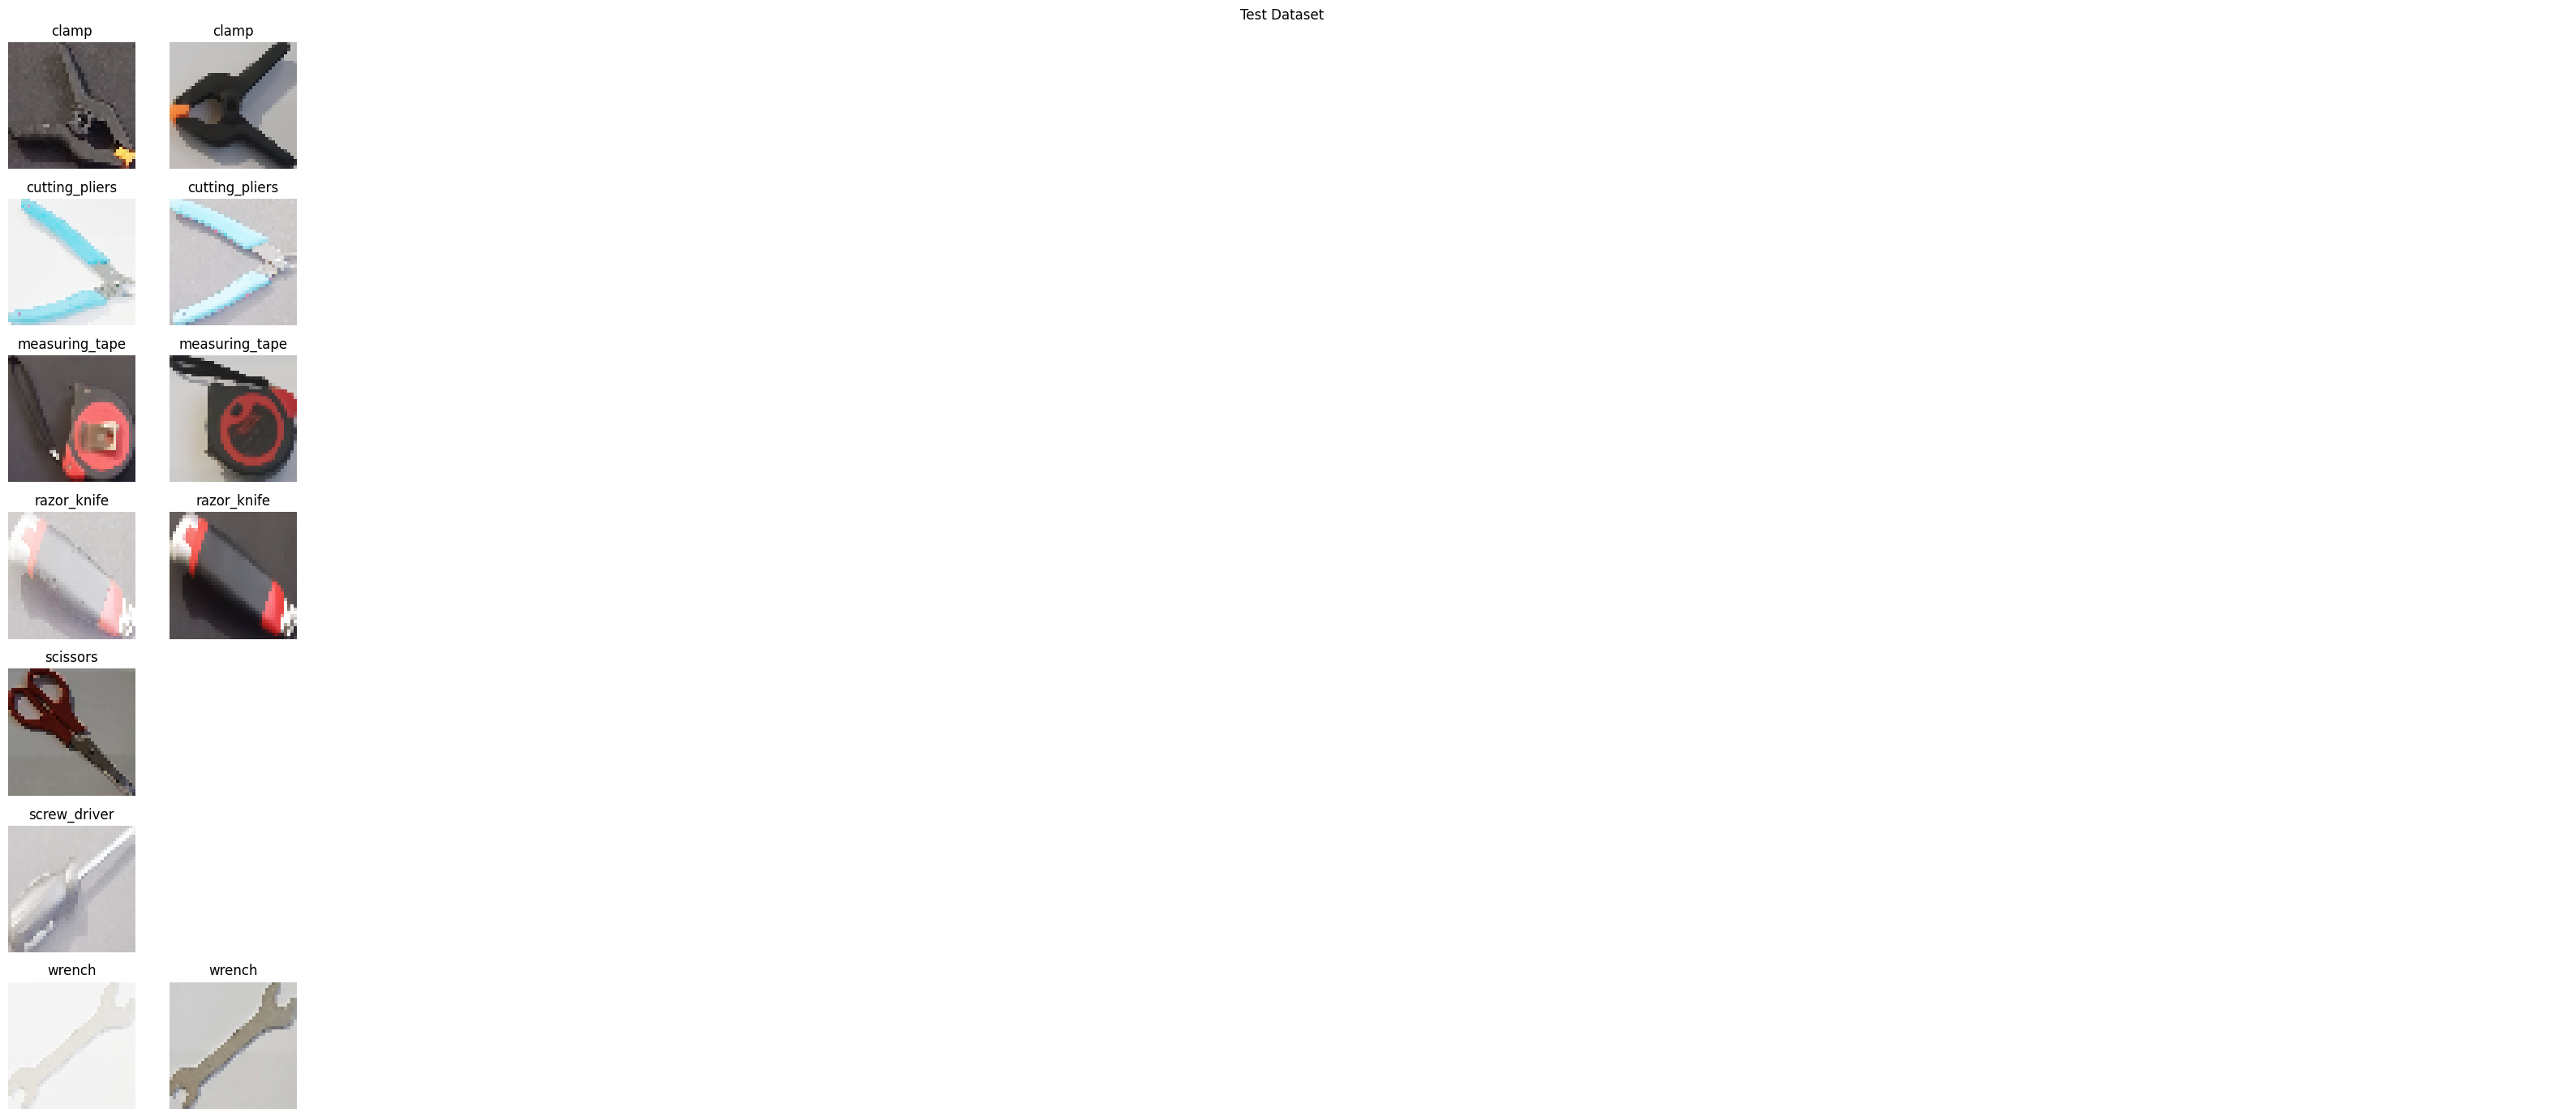

In [123]:
display_images(x_test, y_test, unique_classes, metadata, title="Test Dataset")

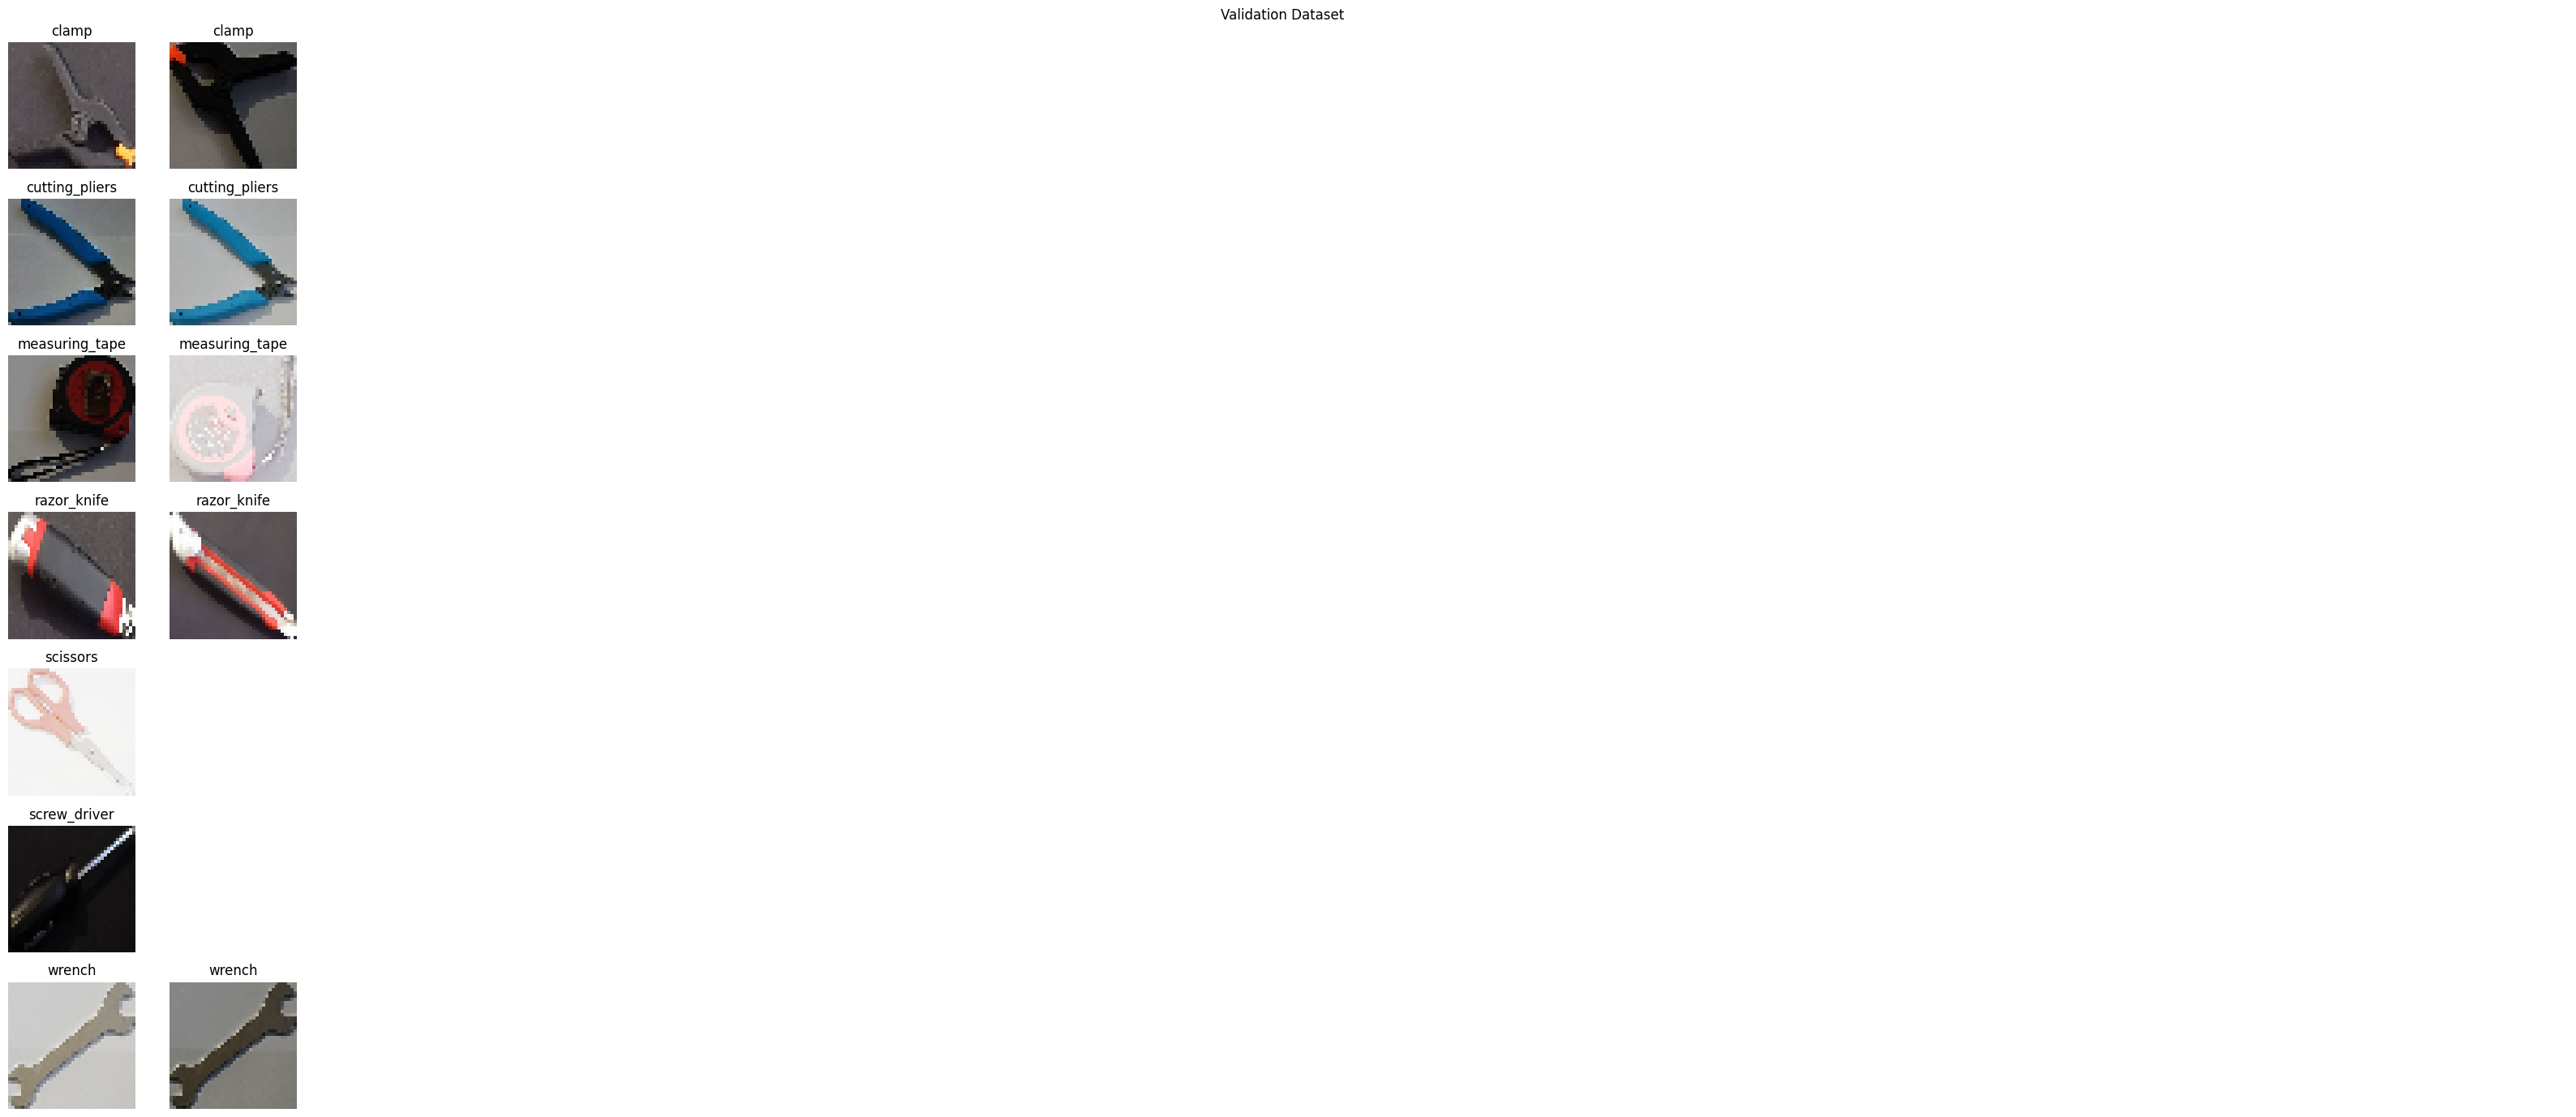

In [124]:
display_images(x_validation, y_validation, unique_classes, metadata, title="Validation Dataset")

In [108]:
# Normalizando os vetores
x_training_norm = np.array(x_training) / 255.0
x_validation_norm = np.array(x_validation) / 255.0
x_test_norm = np.array(x_test) / 255.0

print(x_training_norm.shape)
print(x_validation_norm.shape)
print(x_test_norm.shape)

(88, 40, 40, 3)
(12, 40, 40, 3)
(12, 40, 40, 3)


In [109]:
kernel = (3, 3)  # kernel size of 5x5
pool = (2, 2)  # pool size 2x2

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)),
    keras.layers.MaxPooling2D(pool_size=pool),

    keras.layers.Conv2D(128, kernel, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=pool),

    keras.layers.Conv2D(256, kernel, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=pool),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 40, 40, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,012,042 (7.68 MB)

 Trainable params: 2,012,042 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [111]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['sparse_categorical_accuracy'])

In [112]:
print(x_training_norm.shape)
print(y_training)

(88, 40, 40, 3)
[5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 1 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9
 9 9 2 2 2 2 2 2 2 2 2 2 2 2]


In [113]:
repeated_x_training = x_training_norm.repeat(100, axis=0)
repeated_y_training = y_training.repeat(100)

repeated_x_validation = x_validation_norm.repeat(10, axis=0)
repeated_y_validation = y_validation.repeat(10)

print(repeated_x_training.shape)
print(repeated_y_training.shape)

(8800, 40, 40, 3)
(8800,)


In [114]:
history = model.fit(repeated_x_training,
                    repeated_y_training,
                    validation_data=(x_validation_norm, y_validation),
                    epochs=10,
                    steps_per_epoch=40,
                    batch_size=8,
                    verbose=1,
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 2.1426 - sparse_categorical_accuracy: 0.2402 - val_loss: 0.5965 - val_sparse_categorical_accuracy: 0.7500
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.4247 - sparse_categorical_accuracy: 0.8383 - val_loss: 0.1571 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0909 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.2355 - val_sparse_categorical_accuracy: 0.9167
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.2805 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.0247 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0659 - sparse_categorical_accuracy: 0.9716 - val_loss: 0.0035 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0076 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0010 - val_sparse_categorical_accuracy: 1.0000
Epoch 7

In [115]:
model.save_weights('./model40_rgb.weights.h5', overwrite=True)

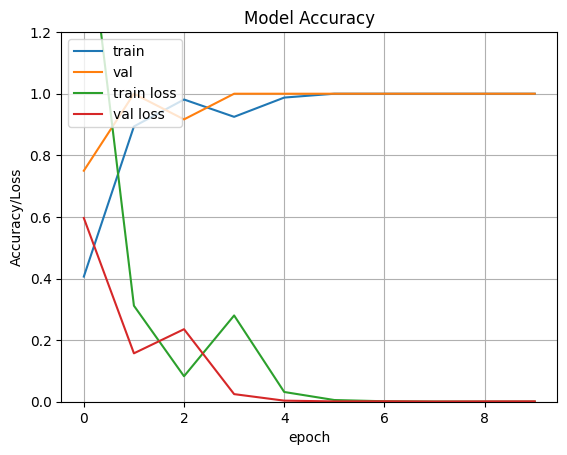

In [120]:
# Accuracy x Epoch plot
plt.grid(True)
plt.gca().set_ylim(0, 1.2) # set the vertical range to [0-1]

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')

plt.legend(['train', 'val', 'train loss', 'val loss'], loc='upper left')

plt.show()

In [135]:
loss, acc = model.evaluate(x_test_norm, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.0491 - sparse_categorical_accuracy: 1.0000
Loss: 0.04905538633465767
Accuracy: 1.0


In [133]:
# f1 score
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_norm)
y_pred = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
F1 Score: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Accuracy:1.00

[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 2]]


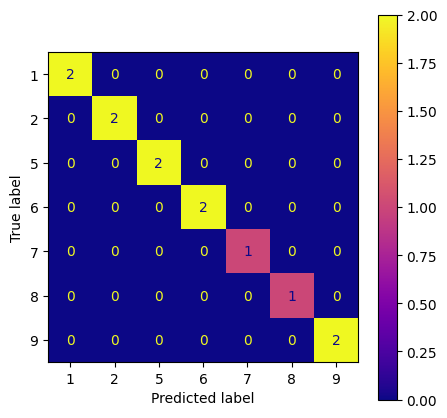

In [131]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_proba = model.predict(x_test_norm)

test_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(test_pred, y_test)
print(f'Accuracy:{acc:.2f}\n')

cm = confusion_matrix(y_test, test_pred)
print(confusion_matrix(y_test, test_pred))


fig, ax = plt.subplots(figsize=(5, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    test_pred,
    ax=ax,
    colorbar=True,
    cmap="plasma"
)

plt.show()